<a href="https://colab.research.google.com/github/drscook/REU_2019/blob/master/main_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

v8
- handles complex (corner) collisions by slightly redirecting particle to avoid them.  Add complexity to the logic in next_state, but should be invisible to the user.  Report any bugs.
- Made it easier to use colab widgets

v7
- force

v6 improvements
- no slip collisions

Major improvements from v3 to v5
- handles false collisions more efficiently
- animations
- wrap walls
- better cleanup
- export to json - easy to write to file if desired

In [0]:
## Graphics

from IPython.display import HTML
import io
import base64
import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline
movie_frame_rate = 40


def interpolate(part, frame_count=100):
    """
    Interpolates between collision events to make a smooth animation
    """
    frame_count = max(frame_count, 1)
    pos_hist = part['pos_hist']
    t_hist   = part['t_hist']
    
    # To make movie smooth, we set frame length so that particle can not travel too far in any frame.
    # Specifically, it is limited to a fixed fraction of the longest flight.
    dx = np.linalg.norm(pos_hist-pos_hist[0], axis=-1)  # length of each flight
    cum_dx = np.cumsum(dx)  # total distance covered by the particle
    max_flight_dx = np.linalg.norm(np.ptp(pos_hist, axis=0))  # find longest flight seen
    max_flight_dx_frame = max_flight_dx / movie_frame_rate  # sets max dist particle can move in a single frame
    max_cum_dx = max_flight_dx_frame * frame_count  # total distance particle can possibly move in the specified number of frame given max_frame_flight
    idx = cum_dx < max_cum_dx + tol  # We cut off the animation once total distance actually traveled exceeds max_cum_dist
    
    # drop data beyond cutoff set above
    pos_hist = pos_hist[idx]
    t_hist   = t_hist[idx]
    vel_hist = part['vel_hist'][idx]
    rot_hist = part['rot_hist'][idx]
    spin_hist = part['spin_hist'][idx]
    accel_hist = np.full_like(vel_hist, fill_value=part.accel)
    
    dt_frame_ave = t_hist[-1] / frame_count  # ave "experiment" time during each frame
    dt_collision = np.diff(t_hist)  # time between consecutive collisions
    frames_interp = np.ceil(dt_collision / dt_frame_ave).astype(int)  # frames to interpolated between consecutive collisions
    frames_interp[frames_interp < 1] = 1  # Make sure its always at least 1
    
    dt = np.append(dt_collision / frames_interp, 0)  # fudge to make shapes align later

    def interp(x):
        x_interp = np.repeat(x[:-1], frames_interp, axis=0)  # repeats the value for each interpolated frame we are making
        x_interp = np.append(x_interp, x[[-1]], axis=0)  # append the last value
        return x_interp

    part_interp = deepcopy(part)
    # For each frame, creates the list [0*dt, 1*dt, 2*dt, ..., (frames_interp-1)*dt] and then concatenates and appends 0
    part['dt_interp']   = np.hstack([dt * np.arange(f) for dt, f in zip(dt, frames_interp)]+[0])
    part['t_interp']    = interp(t_hist) + part['dt_interp']
    part['vel_interp']  = interp(vel_hist)
    part['accel_interp']  = interp(accel_hist)
    part['spin_interp'] = interp(spin_hist)
    
    # position interp - start at collision point and repeatedly add vel*dt until we reach the next collision point
    part['pos_interp']  = interp(pos_hist) + part['vel_interp'] * part['dt_interp'][:,np.newaxis] + part['accel_interp'] / 2 * part['dt_interp'][:,np.newaxis]**2
    
    # rotation interp - start at rotation at collision point and repeatedly add spin*dt until we reach the next collision point
    theta  = interp(rot_hist) + part['spin_interp'] * part['dt_interp']
    # Convert theta to rotation matrices.  Moveaxis puts the "step" axis in the first position; shape is steps x dim x dim
    part['rot_interp']  = np.moveaxis(np.array([[np.cos(theta), -np.sin(theta)],
                                                [np.sin(theta), np.cos(theta)]]
                                              ), -1, 0)
    return part



def draw(part_orig, step_count=None, ax=None, show_arrows=True):
    """
    Draw the system
    """
    part = deepcopy(part_orig)    
    if step_count is None:
        step_count = 100
    step_count = min(step_count, len(part['t_hist'])-1)

    for var in ['t_hist', 'pos_hist', 'vel_hist', 'rot_hist', 'spin_hist']:
        part[var] = part[var][:step_count+1]
    
    frame_count = step_count * movie_frame_rate
    part = interpolate(part, frame_count)
    
    t_interp = part['t_interp']
    pos_interp = part['pos_interp']
    vel_interp = part['vel_interp']
    rot_interp = part['rot_interp']
    dt_interp = np.abs(np.diff(t_interp))

    
    # Get last state
    t = t_interp[-1]
    pos = pos_interp[-1]
    vel = vel_interp[-1]
    rot = rot_interp[-1]

    if ax is None:   # May pass in ax to overlay plots
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_aspect('equal')  # If unequal aspect, collisions may not look right
        ax.grid(False)

    # Draw walls
    for bdy in part['wall_bdy_pts']:
        ax.plot(*bdy, 'k', linewidth=3.0)

    bdy = rot @ part['bdy_pts'] + pos[:,np.newaxis]
    ax.plot(*bdy)

    # Draw arrow for last velocity
    arr = vel / np.linalg.norm(vel) * part['radius'] * 2
    ax.annotate("", xy=pos, xytext=pos+arr, arrowprops=dict(arrowstyle="<-"))

    if step_count > 0:
        # We record steps against wrap walls twice so that the trails looked right.
        # We must not draw trails for the "teleportation" through the walls.
        # We detect them by looking for dt very close to 0.
        big_steps = np.nonzero(dt_interp > tol)[0].tolist()
        for i in big_steps:  # We draw trails for big_steps only
            ax.plot(pos_interp[i:i+2,0], pos_interp[i:i+2,1], 'g:', linewidth=1.2)

        if step_count > 100:
            show_arrows = False

        if show_arrows:  # This got harder with curved trajectories
            t_orig = part['t_hist']
            dt_orig = np.diff(t_orig)
            midtime = (t_orig[1:] + t_orig[:-1]) / 2
            idx = dt_orig >  tol
            midtime = midtime[idx]
            s = np.subtract.outer(midtime, t_interp)
            s[s<=tol] = np.inf
            v = np.argmin(s, axis=1)
            u = v - 1
            heads = pos_interp[u]
            tails = pos_interp[v]
            vecs = tails-heads

            for head, vec in zip(heads, vecs):
                ax.annotate("", xy=head, xytext=head+vec, arrowprops=dict(arrowstyle="<-"))
    return ax


def embed_video(fname):
    """
    Embed .mp4 movie into Jupyter Notebook
    """
    video = io.open(fname, 'r+b').read()
    encoded = base64.b64encode(video)

    display(HTML(data='''<video alt="test" controls>
         <source src="data:video/mp4;base64,{0}" type="video/mp4" />
         </video>'''.format(encoded.decode('ascii'))))

    
def animate(part, movie_time=5, show_trails=True, save=True, embed=True):
    """
    Create animation
    """
    
    interp_only = not (save or embed)
    if interp_only:
        print("Only doing interpolation because both save and embed are false.")
    
    frame_count = movie_time * movie_frame_rate
    print(f"I will attempt to animate {frame_count} frames")
    
    #interpolate the data
    part = interpolate(part, frame_count)
    
    # get interpolated data
    t_interp = part['t_interp']
    pos_interp = part['pos_interp']
    rot_interp = part['rot_interp']
    dt = np.abs(np.diff(t_interp))
    steps = len(dt)
    
    # See Draw function for descriptions
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_facecolor('w')
    
    for bdy in part['wall_bdy_pts']:
        ax.plot(*bdy, 'k', linewidth=3.0)

    # Show experiment time
    time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes)
    bdy_pts = part['bdy_pts']
    bdy = ax.plot([],[], 'r', linewidth=1.0)[0]
    
    # Draw all trails, but make them invisible initially via alpha=0.
    # We will make them appear at the appropriate moment within the update function
    # by setting alpha=1.0.
    trails = []
    for i in range(steps):
        trails.append(ax.plot(pos_interp[i:i+2,0], pos_interp[i:i+2,1], 'g:', alpha=0.0)[0])


    def init():
        time_text.set_text('')
        bdy.set_data(rot_interp[0] @ bdy_pts + pos_interp[[0]].T)
        return [bdy] + trails

    
    big_steps = np.nonzero(dt > tol)[0].tolist()  # exclude wrap arounds
    def update(s):
        time_text.set_text(f"time {t_interp[s]:.2f}")  # run timer
        bdy.set_data(rot_interp[s] @ bdy_pts + pos_interp[[s]].T)  # move particle
        if show_trails:  # make trails appear
            for i in big_steps:  # Do not make trails for wrap around collsions appear, but do make others appear
                if i >= s:
                    break
                trails[i].set_alpha(1.0)
        return [bdy] + trails

    anim = animation.FuncAnimation(fig, update, init_func=init,
                                   frames=frame_count, interval=movie_time*1000/frame_count, 
                                   blit=True)
    plt.close()

    if save:
        anim_file = part['save_path'] + 'animation.mp4'
        try:
            anim.save(filename=anim_file)  # save animation as mp4
        except:
            install = input("First animation attempt failed.  It might be because ffmpeg is not installed.  Shall I try to install ffmpeg and try again (y/n)?")
            if install in ['y', 'Y', 'yes', 'Yes', 'YES']:  # Install ffmpeg
                os.system('add-apt-repository ppa:mc3man/trusty-media ')
                os.system('apt-get update')
                os.system('apt-get install --upgrade ffmpeg')
                os.system('apt-get install --upgrade frei0r-plugins')
                anim.save(filename=anim_file)    # save animation as mp4
            else:
                print("OK, I give up.  Returning the anim object.")
                return anim
        if embed:
            embed_video(anim_file)    # show in notebook - resizing issues
    elif embed:
        display(HTML(anim.to_jshtml()))        # diplays video in notebook

    return part, anim

In [0]:
import os
import json
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import pytz
cst = pytz.timezone('US/Central')
path = "/content/"

tol = 1e-4



class Particle():
    def __init__(self, dim=2, radius=1, mass=1, gamma=1/np.sqrt(2), force=None, save=False):
        self.timestamp = datetime.datetime.now(cst).strftime('%Y-%m-%d_%H-%M-%S')
        self.save_path = path+self.timestamp+"/"
        self.save = save
        self.dim = dim
        self.radius = radius
        self.mass = mass

        self.force = None
        self.accel = 0.0
        if force is not None:
            if np.linalg.norm(force) > tol:
                self.force = np.array(force)
                self.accel = self.force / self.mass
            
        self.gamma = gamma  # mass distribution constant
        self.inertia = self.mass * self.gamma * self.radius**2
        g = 1 + gamma**2
        a = (1 - gamma**2) / g
        b = 2 * gamma / g
        self.no_slip_matrix = np.array([[-1, 0, 0],
                                        [ 0 ,a,-b],
                                        [ 0,-b,-a],
                                       ])
        self.vars = ['t', 'pos', 'vel', 'rot', 'spin', 'wall_idx', 'wrap_count', 'phi', 'arclength']  # vars to record at each step

    #__getitem__ and __setitem__ allow you syntax choices.  Suppose you want to 
    # get or set an attribute named "kai".  You can now either use
    # part.kai or part["kai"].  Sometimes the second  is more convenient than
    # the first.  Without __get_item and __setitem__, we can only use the first one.
    def __getitem__(self, key):
        return self.__dict__[key]

    def __setitem__(self, key, val):
        self.__dict__[key] = val


    def get_bdy_pts(self):
        """
        Returns boundary points for plots
        """
        try:
            return self.bdy_pts
        except:
            s = np.linspace(-np.pi, np.pi, 100)
            s = np.append(s, 0)  # appending 0 draws the equator line through center to show spin
            self.bdy_pts = self.radius * np.array([np.cos(s), np.sin(s)])
            return self.bdy_pts


    def check_real_collision_get_arclength(self):
        """
        Because we allow parts of flat and circle walls but .get_dts detect collisions with missing
        parts, we check before applying the collision law where the collision is again
        is real or imaginary part of the wall.
        """
        arclengths = [wall.check_real_collision_get_arclength(self) for wall in Walls]  # run this method in each wall
        self.arclength = np.sum(arclengths)
        if self.arclength >= 0:
            self.real_collision = True
        else:
            self.real_collision = False
            self.arclength = np.nan
        return self.real_collision

    
    def get_phi(self):
        """
        Compute angle outgoing velocty makes with normal vector at collision point
        """
        F = Walls[self.wall_idx].get_frame(self).T  # orthonormal frame
        v = part.vel / np.linalg.norm(part.vel)  # unit vector in direction of vel
        v_frame = v @ F  # vel in frame coordinates, normal component is entry 0
        self.phi = np.arccos(abs(v_frame[0])) * np.sign(v_frame[1])  # arccos gives angle; sign determines if positive or negative
        return self.phi


    def record_state(self):
        """
        Records states as simulation runs
        """
        for var in self.vars:
            hist = var+"_hist"
            cur = self[var]  # current value
            try:
                self[hist].append(cur.copy())  # write current value into hist; copy if possible
            except:
                self[hist].append(cur)
                
                
    def reset_history(self):
         for var in self.vars:
            hist = var+"_hist"  # for each var, there is a corresponding _hist to records its value
            self[hist] = []       


    def clean_up(self):
        """
        Final tasks after simulation complete
        """
        # Cast lists to numpy arrays and set dtype to float32 to save space
        for key, val in self.__dict__.items():
            if isinstance(val, list) or isinstance(val, np.ndarray):
                try:
                    self[key] = np.asarray(val).astype(np.float32)
                except:
                    pass

        # Create record in json format
        self.json_record = json.dumps(self.__dict__, cls=MyEncoder, separators=(', ',':'))
        
        # Save to file, if desired
        if self.save:
            # make save path if is does not exist
            if not os.path.exists(self.save_path):
                os.makedirs(self.save_path)
            # Write to file
            with open(self.save_path+'data.json', 'w') as file:
                file.write(self.json_record)
        return self.json_record


class MyEncoder(json.JSONEncoder):
    """
    Custom JSON Encoder to cast numpy object to base python
    """
    def default(self, z):
        if isinstance(z, np.ndarray):
            return z.tolist()
        elif isinstance(z, np.int64):
            return int(z)
        return super().default(z)

        

class Wall():
    # See note in particle class
    def __getitem__(self, key):
        return self.__dict__[key]

    def __setitem__(self, key, val):
        self.__dict__[key] = val
    
    def specular_law(self, part):
        """
        Applies specular collision law v_out = v_in - 2*(v_in @ normal)normal.
        """
        n = self.get_normal(part)
        part.vel -= 2 * (n @ part.vel) * n
        return part.vel
        
        
    def wrap_law(self, part):
        """
        Applies wrap around law
        """

        # To make images look right, we must record state both before and after wrapping.
        # But we can't record arclength and phi both times - this woudl double count these collisions.
        # So we must be careful - the fix is a little delicate.
        # At this point, we have computed new arclength, but not new phi.
        # So, for the first record, we report correct new arclength but phi = nan.
        # For the second record, we report arclength = nan and correct new phi.
        # We will drop nan's when computing statistics later, so that exactly one arclength and phi
        # remains from this collision.
        part.phi = np.nan
        part.record_state()
        part.arclength = np.nan
        # Second record step will be the usual one that happens in fuction next_state.

        # Perform wrap around
        old = self.wall_idx  # wall_idx that was hit and wrapping away from
        new = self.wrap_wall_idx  # wall_idx wrapping to
        part.wall_idx = new  # tell part its new wall_idx
        part.wrap_count[old] += 1
        part.wrap_count[new] -= 1
        
        # Get frames for old and new walls
        F_old = self.get_frame(part).T
        F_new = Walls[new].get_frame(part).T

        # Compute new position
        dx_old = part.pos - self.base  # dx_old in standard coordinates
        dx_frame_old = dx_old @ F_old  # dx_old in frame coordinates
        dx_frame_new = dx_frame_old.copy()   # dx_new in frame coordinates
        dx_frame_new[0] *= -1  # flips normal coordinate so particle appears on correct side of new wall
        if self.flip_pos:
            dx_frame_new[1] *= -1  # optionally flips tangential coordinate in case old and new walls have tangents going in different directions
        dx_new = F_new @ dx_frame_new  # dx_new in standard coordinates
        part.pos = dx_new + Walls[new].base  # new part positions

        # Compute new velocity
        v_frame_old = part.vel @ F_old  # vel_old in frame coordinates
        v_frame_new = v_frame_old.copy()
        v_frame_new[0] *= -1  # flips normal coordinate so particle is moving toward correct side of new wall
        if self.flip_vel:
            v_frame_new[1] *= -1  # optionally flips tangential coordinate in case old and new walls have tangents going in different directions
        part.vel = F_new @ v_frame_new  # vel_new in standard coordinates
        
    
    def no_slip_law(self, part):
        """
        Implements no-slip collision law
        """
        F = self.get_frame(part).T
        v_frame = part.vel @ F
        s = np.append(v_frame, part.spin)
        new_s = part.no_slip_matrix @ s
        part.spin = new_s[-1]
        v_frame = new_s[:-1]
        part.vel = F @ v_frame
        return part.vel

        
    def assign_law(self):
        """
        Defines wall method "resolve_collision" for specified collision_law
        """
        if self.collision_law == "specular":
            self.resolve_collision = self.specular_law
        elif self.collision_law == "wrap":
            if self.wall_type != 'flat':
                raise Exception('Wrap_law only defined for flat walls (currently)')
            if self.wrap_wall_idx is None:
                raise Exception("Must specify wrap_wall_idx to use wrap_law")
            if self.hard:
                # Wrap_law should usually use a soft wall so particle center can reach the wall; otherwise it will jump.
                # Ask user if we should switch to a soft wall
                make_soft = input("Wall assigned wrap wall and hard=True.  Particle will stop before the wall and jump to wrap wall.  Do you want me to make it a soft wall (y/n)?")
                if make_soft in ['y', 'Y', 'yes', 'YES', 'Yes']:
                    self.hard = False
            self.resolve_collision = self.wrap_law
        elif self.collision_law == 'no_slip':
            self.resolve_collision = self.no_slip_law
        else:
            raise Exception(f"Unknown collision law {self.collision_law_name} specified")

            
    def solver(self, coefs, ignore_smallest=False):
        coefs = np.asarray(coefs)
        if coefs.ndim < 2:
            coefs = coefs[np.newaxis]
        elif coefs.ndim > 2:
            raise Exception("coefs must be 2D array")

        roots = []
        for c in coefs:
            c = c.tolist()
            # remove all leading zeros
            deg = len(c)-1
            while abs(c[0]) < tol:
                c.pop(0)
                deg -= 1
                if deg < 1:
                    r = []
            if deg < 1:
                r = []
            elif deg == 1:  # linear
                r = [-c[1] / c[0]]
            elif deg == 2:  # quadratic
                d = c[1]**2 - 4*c[0]*c[2]
                if d < 0:  # complex
                    r = []
                else:  # real
                    u = -c[1] / (2*c[0])
                    v = np.sqrt(d) / (2*c[0])
                    r = [u+v, u-v]
            else:  # cubic or higher
                r = np.roots(c)
            roots.append(r)

        roots = np.hstack(roots)
        if len(roots) > 0:
            ## remove closest to zero if needed
            if ignore_smallest:
                idx = np.argmin(np.abs(roots))
                roots[idx] = np.inf

            ## remove non-real roots
            idx = np.abs(np.imag(roots)) > tol
            roots[idx] = np.inf
            roots = np.real(roots)

            ## remove negative roots
            idx = roots < 0
            roots[idx] = np.inf
        return roots
            
    def extend_frame(self, A):
        """
        An overly fancy method to extend a set of ROW vectors to an orthonormal frame.
        Recall that and orthonormal frame must contain exactly self.dim many vectors
        that are mutually orthogonal and unit length.
        
        If no vectors are supplied, returns standards unit vectors along axes.
        If one or more vectors are supplied, applies QR-factorization to:
        1. make supplied vectors mutually orthogonal and unit length
        2. generate additional vectors that are orthogonal and unit length if fewer than
        self.dim many vectors were supplied.
        """
        
        A = np.asarray(A)
        if A.ndim == 0:
            return np.eye(self.dim)
        elif A.ndim == 1:
            A = A[:,np.newaxis]  # make into 2D-array
            
        # Though we store vectors are ROWS of A, np.linalg.qr wants them as columns.
        # So we tranpose if nrows <= ncols
        m, n = A.shape
        if m <= n:  
            A = A.T
            m, n = n, m
        
        # The heavy lifting to apply QR-factorization.
        # Flag 'complete' asks np.linalg.qr to generate additional vectors if necessary.
        F = np.linalg.qr(A, 'complete')[0]
        F = F.T
        
        # np.linalg.qr might flip the sign of vectors supplied in A.  We flip them back.
        s = np.sign(F@A)
        F[:n] *= np.diag(s).reshape(-1,1)
        
        return F

           
    def cap_endpoints(self):
        """
        The collision detection methods .get_dts of partial walls in interior of billiard cell
        can be fooled by nearly tangentially incoming particle trajectories.  We prevent
        this by placing hard half-circle caps of radius 0 at the walls endpoint.
        The vector between last 2 walls points is the first axes vector (north)."
        """
        
        # get bdy_pts to determine where endpoints are and what the "north" axis is
        bdy_pts = self.get_bdy_pts().T
        Caps = []
        
        north = bdy_pts[0] - bdy_pts[1]
        new_wall = SphereWall(base=bdy_pts[0], radius=0.0, north=north, collision_law=self.collision_law,
                              max_polar_angle=np.pi/2*1.01, outside=True, inside=False)
        Caps.append(new_wall)
        
        north = bdy_pts[-1] - bdy_pts[-2]
        new_wall = SphereWall(base=bdy_pts[-1], radius=0.0, north=north, collision_law=self.collision_law,
                              max_polar_angle=np.pi/2*1.01, outside=True, inside=False)
        Caps.append(new_wall)
        
        return Caps

        
class FlatWall(Wall):
    def __init__(self, base, radius, normal, collision_law="specular", hard=True, two_sided=False,
                 wrap_wall_idx=None, flip_pos=True, flip_vel=True):
        self.wall_type = 'flat'
        self.collision_law = collision_law
        self.base = np.array(base)  # position vector for center of wall
        self.dim = len(self.base)
        self.two_sided = two_sided  # set True if both sides of wall can be hit (interior walls)
        self.hard = hard  # set False if particle center can reach the wall - typically for wrap walls only
        self.radius = radius  # distance from base to endpoint
        self.total_arclength = 2 * self.radius  # length of wall
        if self.two_sided:
            self.total_arclength *= 2  # double the length if both sides can be hit
        
        n = normal / np.linalg.norm(normal)
        t = [-n[1], n[0]]
        self.normal = np.array(n)
        self.tangent = np.array(t)
        self.axes = np.array([n, t])
        
        self.wrap_wall_idx = wrap_wall_idx  # if this is a wrap wall, which wall it wraps to
        self.flip_pos = flip_pos  # if the wrap wall's tangent is going opposite of this wall
        self.flip_vel = flip_vel  # if the wrap wall's tangent is going opposite of this wall
        self.assign_law()

    def get_normal(self, part):
        """
        Since flat wall has the same normal everywhere, get_normal simply returns that vector
        """
        return self.normal

    def get_frame(self, part):
        """
        Since flat wall has the same frame everywhere, get_normal simply returns that frame.
        Recall that the no_slip law expects the "outward" normal which points toward the other side of the wall from where the particle is.
        This happens if dx@F[0] is negative.  In this case, flip the frame.
        """
        F = self.axes.copy()
        dx = part.pos - self.base
        if dx @ F[0] > tol:
            F *= -1
        return F

    def get_dts(self, part):
        """
        Finds time(s) when particle would next hit this wall.
        """
        if part.force is None:
            c0 = 0.0
        else:
            c0 = part.accel/2 @ self.normal
        c1 = part.vel @ self.normal  # normal component of vel
        dx = part.pos - self.base  # vector from base of wall to center of particle
        c2 = dx @ self.normal  # normal component of dx
        r = part.radius * self.hard  # if hard, make a band of width part.radius around wall.  If soft, do not.
        if r > 0:
            coefs = [[c0, c1, c2-r], [c0, c1, c2+r]]
        else:
            coefs = [c0, c1, c2]

        ignore_smallest = (self.wall_idx == part.wall_idx)
        self.dt = self.solver(coefs, ignore_smallest)
        return self.dt

                
    def check_real_collision_get_arclength(self, part):
        """
        Checks if collision is against removed portion of wall & compute arclength position
        """
        if self.wall_idx < part.wall_idx:  # if particle hits a different wall with bigger wall_idx, count my entire arclength
            self.arclength = self.total_arclength
        elif self.wall_idx > part.wall_idx:  # if particle hits a different wall with smallerbigger wall_idx, count none of my arclength
            self.arclength = 0
        else:  # if particle hits me, compute how much arclength to count
            dx = part.pos - self.base  # vector from base of wall to center of particle
            F = self.get_frame(part).T  # frame
            dx_frame = dx @ F  # dx in frame coordinates
            if np.abs(dx_frame[1]) > self.radius:  # if tangential component of dx is bigger than my radius, it hit a removed part.  Its not a real collision.
                self.arclength = -np.inf  # return -inf so part.check_real... knows I determined this is not a real collision.
            else:
                self.arclength = dx_frame[1] + self.radius  # shifts so arclength is 0 to total_arclength; had been -radius to +radius
            # if two sided, the side with negative normal dx is 0 to total_arclength/2 and collision had positive normal dx
            # and the side with positive normal dx is total_arclength/2 to total_arclength
            if self.two_sided and dx_frame[0] >= 0:
                self.arclength += 2 * self.radius
        return self.arclength
    
    
    def get_bdy_pts(self):
        """
        Returns boundary points for plots
        """
        try:  # returns bdy_pts if previously computed
            return self.bdy_pts
        except:
            s = np.linspace(-self.radius, self.radius, 100)
            self.bdy_pts = (self.base + self.tangent * s[:,np.newaxis]).T
            return self.bdy_pts

                
class SphereWall(Wall):
    def __init__(self, base, radius, north=None, max_polar_angle=np.pi,
                 collision_law="specular", wrap_wall_idx=None, hard=True,
                 inside=False, outside=False):
        self.wall_type = 'sphere'
        self.collision_law = collision_law
        self.base = np.array(base)  # center point
        self.dim = len(self.base)
        self.hard = hard  # see FlatWall
        self.radius = radius  # radius of sphere
        # reference axes for incomplete spheres: axes[0] is the "north" pole.  NOT NORMAL VECTOR - that depends on collision point
        n = north / np.linalg.norm(north)
        t = [-n[1], n[0]]
        self.north = n
        self.axes = np.array([n, t])
        
        
        # max_polar_angle determines what portion of sphere is really present
        assert 0 <= max_polar_angle <= np.pi, f"max_polar_angle must lie between 0 and pi; got {max_polar_angle}"
        self.max_polar_angle = max_polar_angle
        # polar projection of dx = part.pos - self.base must be greater than min_polar_projection to create a real collision.  Else is it a false collision.
        self.min_polar_projection = np.cos(max_polar_angle)
        self.hole_radius = self.radius * np.sin(np.pi - self.max_polar_angle)  # radius of hole create by missing part of sphere
        self.two_sided = (self.hole_radius > part.radius)  # sphere is two-sided if particle can get through the hole
        if self.two_sided:
            self.inside = True
            self.outside = True
        else:  # if not two-sided, user must specify which side the particle is stuck on
            self.inside = inside
            self.outside = outside
            # ^ is python's xor symbol.  Exactly one of inside and outside must be True
            assert self.inside ^ self.outside, f"Exactly one of inside or outside must be explicitly set True because hole is too small for particle to pass through."
                
        # inside arclength is 0 if inside=False.  Else, it the circumference of the real part of the circle minus the particle's radius, if wall is hard
        self.inside_arclength = 2 * self.max_polar_angle * self.inside * (self.radius - part.radius * self.hard)
        # inside arclength is 0 if outside=False.  Else, it the circumference of the real part of the circle plus the particle's radius, if wall is hard
        self.outside_arclength = 2 * self.max_polar_angle * self.outside * (self.radius + part.radius * self.hard)
        self.total_arclength = self.inside_arclength + self.outside_arclength
        self.assign_law()
    
    
    def get_normal(self, part):
        """
        Normal depends on collision point and must be computed at each step.  It is the unit vector from part center to wall center.
        """
        dx = part.pos - self.base
        return dx / np.linalg.norm(dx)
    
    
    def get_frame(self, part):
        """
        Frame depends on collision point and must be computed at each step.  Get normal vector and then extend to frame.
        Recall that the no_slip law expects the "outward" normal which points toward the other side of the wall from where the particle is.
        Note that n=part.pos-self.base gives a normal vector pointing from circle center to particle.
        If particle is inside of circle, this normal is an "outward" pointing normal.  So the frame is correct.
        If particle is outside of circle,  this normal is an "inward"  pointing normal.  So the frame is must be flipped.
        """
        n = self.get_normal(part)
        t = [-n[1], n[0]]
        F = np.array([n, t])
        dx = part.pos - self.base
        if np.linalg.norm(dx) > self.radius:
            F *= -1
        return F

    
    def get_dts(self, part):
        """
        Finds time(s) when particle would next hit this wall.
        Let Collision occurs when |part.pos - self.base|^2 = (self.radius +- part.radius)^2.
        Write part.pos(t) = part.pos(0) + t * part.vel.  Gives a quadratic whose zeros are dt's.
        """
        dx = part.pos - self.base  # vector from circle center to particle center
        v = part.vel
        if part.force is None:
            c0 = 0.0
            c1 = 0.0
            c2 = v @ v  # particle speed ^ 2
        else:
            a = part.accel / 2
            c0 = a @ a
            c1 = 2 * a @ v
            c2 = v @ v + 2 * a @ dx
        c3 = 2 * v @ dx
        c4 = dx @ dx
        R = self.radius
        r = part.radius * self.hard  # if hard, make concentric circles inside and outside wall by part.radius; if soft do not
        if (R > tol) and (r > tol):
            coefs = [[c0, c1, c2, c3, c4-(R-r)**2], [c0, c1, c2, c3, c4-(R+r)**2]]
        else:
            coefs = [c0, c1, c2, c3, c4-(R-r)**2]
        ignore_smallest = (self.wall_idx == part.wall_idx)
        self.dt = self.solver(coefs, ignore_smallest)
        return self.dt

    
    def check_real_collision_get_arclength(self, part):
        """
        Checks if collision is against removed portion of wall & compute arclength position
        """
        if self.wall_idx < part.wall_idx:  # if particle hits a different wall with bigger wall_idx, count my entire arclength
            self.arclength = self.total_arclength
        elif self.wall_idx > part.wall_idx:  # if particle hits a different wall with smallerbigger wall_idx, count none of my arclength
            self.arclength = 0
        else:  # if particle hits me, compute how much arclength to count
            dx = part.pos - self.base
            mag = np.linalg.norm(dx)  # distance from part center to wall center
            dx /= mag  # unit vector from part center to wall center
            F = self.axes.T  # frame
            dx_frame = dx @ F  # dx in frame coordinates
            if dx_frame[0] < self.min_polar_projection:  # if polar projection is less than min_polar_projection, this is not a real collision
                self.arclength = -np.inf
            else:
                polar_angle = (np.pi - np.arccos(dx_frame[0])) * np.sign(dx_frame[1])  # angle of dx relative to "north"; sign of tangential projection determines +/-
                polar_angle += self.max_polar_angle  #shift from +/- max _polar_angle to [0, 2*max_polar_angle]
                if mag < self.radius:  # inside of circle
                    self.arclength = polar_angle * (self.radius - part.radius * self.hard)
                else:  #outside of circle
                    self.arclength = polar_angle * (self.radius + part.radius * self.hard)
                    self.arclength += self.inside_arclength
        return self.arclength
        

    def get_bdy_pts(self):
        """
        Returns boundary points for plots
        """
        try:
            return bdy_pts
        except:
            s = np.linspace(-self.max_polar_angle, self.max_polar_angle, 100)
            self.bdy_pts = np.array([np.cos(s), np.sin(s)]) * self.radius
            self.bdy_pts = self.axes.T @ self.bdy_pts
            self.bdy_pts += self.base[:,np.newaxis]
            return self.bdy_pts
                
            
                                




def next_state(part, Walls):
    """
    Evolve system one step
    """
    # A complex collision involves multiple walls (corner).  We can not resolve them.
    # We check for them and avoid them by slightly redirecting the particle.
    # Specifically, we rotate the velocity slightly in the normal direction at the
    # point of last collision.

    
    # A false collision occurs on a removed portion of a wall.
    # For example, a half circle behaves like a full circle when finding DT.
    # We move the particle forward and check if the collision occurred on missing part.
    # If so, move the particle back, set the associated entry in DT to np.inf, and try again.

    
    # get dts from each wall; each wall may return 0, 1, or many.  M = most dt's reported by a single wall
    complex_collision = True
    while complex_collision:
        L = [len(wall.get_dts(part)) for wall in Walls]  # computes dts at each wall and records how many dts each wall reports
        N = max(L)  # most dts reported by a single wall
        M = len(Walls)  # number of wall
        DT = np.full(shape=(M,N), fill_value=np.inf)  # MxN array to hold dts
        for i, l in enumerate(L):
            DT[i, :l] = Walls[i].dt  # write dt's from wall i into row i
        DT[DT < 0] = np.inf  # set any negative's to np.inf

    
        # attempt to move using the smallest dt and check if its complex or false collision.
        # If complex, rotate the velocity and start next_state again (recompute DT).
        # If false, move back where it started, set that entry of DT to np.inf, and try again.
        # Note we do NOT need to recompute DT to handle false collisions - just find
        # the next smallest positive DT (after setting the prior to np.inf) and try again.
        
        false_collision = True
        while false_collision:
            part.dt = np.min(DT)
            assert not np.isinf(part.dt), "No more collisions detected - particle escaped the chamber"
            where_dt = np.abs(DT - part.dt) < tol
            num_col = np.sum(where_dt)
            if num_col == 1:
                complex_collision = False            
                row, col = np.unravel_index(DT.argmin(), DT.shape)  # What slot contains the smallest positive time
                part.wall_idx = row
                next_wall = Walls[row]

                # Move particle
                dx = part.vel * part.dt + part.accel / 2 * part.dt**2
                part.pos += dx

                # check if this is a real or false collision (false = against part of wall that has been removed)
                if part.check_real_collision_get_arclength():  # if real collision, great!  We found next collision.  Compute things and resolve the collision.
                    false_collision = False
                    part.t += part.dt
                    part.vel += part.accel * part.dt
                    part.rot += part.spin * part.dt
                    next_wall.resolve_collision(part)
                    part.get_phi()
                    break
                else:  # if not real collision, move the particle back and try again with next smallest dt
                    false_collision = True
                    part.pos -= dx
                    DT[row, col] = np.inf
            else:
                print("Complex collision detected.  Redirecting particle slightly toward normal to avoid it.")
                complex_collision = True
                F = Walls[part.wall_idx].get_frame(part).T
                v_frame = part.vel @ F
                w = (v_frame[::-1]**2) * tol
                w[1] *= -1
                w = np.sqrt(1 + w)
                v_frame *= w
                part.vel = F @ v_frame
                break

    return part, Walls



def run(part, Walls):
    """
    Run the system
    """

    # Preliminaries
    Caps = []
    for i, wall in enumerate(Walls):  # Cap two-sided walls
        if wall.two_sided:
            Caps.extend(wall.cap_endpoints())
    Walls.extend(Caps)
            
    for i, wall in enumerate(Walls):  # Tell each wall what slot in Walls they are in
        Walls[i].wall_idx = i

    part.wall_bdy_pts = np.array([wall.get_bdy_pts() for wall in Walls])  # Record wall_bdy_pts in part of convenience later
    part.get_bdy_pts()

    part.rot = 0.0
    part.t = 0
    part.check_real_collision_get_arclength()
    part.get_phi()
    
    # wrap_count tracks how many time particle passes through each wrap wall
    part.wrap_count = np.zeros(len(Walls), int)
    part.reset_history()
    part.record_state()

    ## Run it
    for i in range(steps):
#         print(f"step {i}")

        part, Walls = next_state(part, Walls)  # evolves the system forward one step
        part.record_state()

    return part.clean_up()

Complex collision detected.  Redirecting particle slightly toward normal to avoid it.


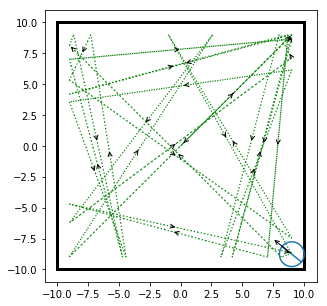

In [46]:
## Complex Collision

np.seterr(all='raise')  # stops program when "warnings" occur.  Default is to continue, but this option makes debugging easier
np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 50
dim = 2

polygon_sides = 4
polygon_radius_inscribed = 10
assert polygon_sides % 2 == 0, "I only know how to wrap with an even number of sides"
offset = int(polygon_sides / 2)


######### Make particle #########
part = Particle(radius=1.0, save=True)


######### Make walls #########
Walls = []

length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
    n = np.array([np.cos(theta), np.sin(theta)])
    b = n * polygon_radius_inscribed
    wrap_wall_idx = (i + offset) % polygon_sides
    new_wall = FlatWall(base=b, normal=n, radius=length, collision_law='no_slip')
    Walls.append(new_wall)


######### Initialize Particle #########
start_wall_idx = 3
part.wall_idx = start_wall_idx
start_wall = Walls[start_wall_idx]
part.pos = np.array([0.0,0.0])
part.vel = np.array([1.0,1.0])
part.spin = 2.0


######### Run it #########
run(part, Walls)


######### Draw history #########
ax = draw(part, step_count=30)
plt.show()

######### Animate #########
# %time part, anim = animate(part, movie_time=5, show_trails=True, save=True)

Complex collision detected.  Redirecting particle slightly toward normal to avoid it.


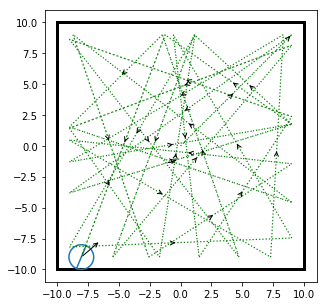

In [49]:
#@title Interactive {run: "auto"}

start_wall_idx = 3
part.wall_idx = start_wall_idx
start_wall = Walls[start_wall_idx]
part.pos = np.array([0.0,0.0])
part.vel = np.array([1.0,1.0])

part.spin = 1 #@param {type:"slider", min:0, max:2, step:0.1}

######### Run it #########
run(part, Walls)

######### Draw history #########
ax = draw(part, step_count=30)
plt.show()


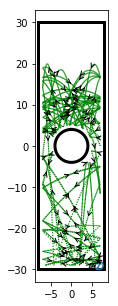

I will attempt to animate 200 frames


CPU times: user 18.8 s, sys: 12 s, total: 30.8 s
Wall time: 16.1 s


In [4]:
## Force
np.seterr(all='raise')  # stops program when "warnings" occur.  Default is to continue, but this option makes debugging easier
np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 100
dim = 2

channel_radius = 8
channel_length = 30


######### Make particle #########
part = Particle(radius=1.0, force = [0.0, -3.0], save=True)


######### Make walls #########
Walls = []

new_wall = FlatWall(base=[channel_radius,0], normal=[1,0], radius=channel_length, collision_law='no_slip')
Walls.append(new_wall)


new_wall = FlatWall(base=[-channel_radius,0], normal=[-1,0], radius=channel_length, collision_law='no_slip')
Walls.append(new_wall)


new_wall = FlatWall(base=[0,channel_length], normal=[0,1], radius=channel_radius, collision_law='no_slip',)
#                     wrap_wall_idx=3, hard=False, flip_pos=True, flip_vel=True)
Walls.append(new_wall)


new_wall = FlatWall(base=[0,-channel_length], normal=[0,-1], radius=channel_radius, collision_law='no_slip',)
#                     wrap_wall_idx=2, hard=False, flip_pos=True, flip_vel=True)
Walls.append(new_wall)


scatterer_radius = 4
new_wall = SphereWall(base=[0.0, 0.0], radius=scatterer_radius, max_polar_angle = np.pi, outside=True,
                      north=[0,-1], collision_law='no_slip')
Walls.append(new_wall)


######### Initialize Particle #########
start_wall_idx = 0
part.wall_idx = start_wall_idx
start_wall = Walls[start_wall_idx]
part.pos = start_wall.base - start_wall.normal * part.radius
part.vel = np.array([-4.0, 10.0])
part.spin = 2.0


######### Run it #########
run(part, Walls)


######### Draw history #########
ax = draw(part, step_count=300)
plt.show()

######### Animate #########
%time part, anim = animate(part, movie_time=5, show_trails=True, save=True)

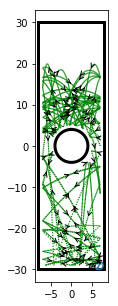

In [0]:
ax = draw(part, step_count=100)
plt.show()

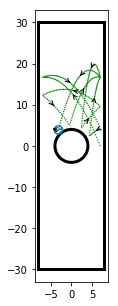

I will attempt to animate 200 frames


CPU times: user 19.8 s, sys: 12.5 s, total: 32.3 s
Wall time: 16.8 s


In [0]:
## Force
np.seterr(all='raise')  # stops program when "warnings" occur.  Default is to continue, but this option makes debugging easier
np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 1000
dim = 2

channel_radius = 8
channel_length = 30


######### Make particle #########
part = Particle(radius=1.0, force = [0.0, -3.0], save=True)


######### Make walls #########
Walls = []

new_wall = FlatWall(base=[channel_radius,0], normal=[1,0], radius=channel_length, collision_law='no_slip')
Walls.append(new_wall)


new_wall = FlatWall(base=[-channel_radius,0], normal=[-1,0], radius=channel_length, collision_law='no_slip')
Walls.append(new_wall)


new_wall = FlatWall(base=[0,channel_length], normal=[0,1], radius=channel_radius, collision_law='wrap',
                    wrap_wall_idx=3, hard=False, flip_pos=True, flip_vel=True)
Walls.append(new_wall)


new_wall = FlatWall(base=[0,-channel_length], normal=[0,-1], radius=channel_radius, collision_law='wrap',
                    wrap_wall_idx=2, hard=False, flip_pos=True, flip_vel=True)
Walls.append(new_wall)


scatterer_radius = 4
new_wall = SphereWall(base=[0.0, 0.0], radius=scatterer_radius, max_polar_angle = np.pi, outside=True,
                      north=[0,-1], collision_law='no_slip')
Walls.append(new_wall)


######### Initialize Particle #########
start_wall_idx = 0
part.wall_idx = start_wall_idx
start_wall = Walls[start_wall_idx]
part.pos = start_wall.base - start_wall.normal * part.radius
part.vel = np.array([-4.0, 10.0])
part.spin = 2.0


######### Run it #########
run(part, Walls)


######### Draw history #########
ax = draw(part, step_count=10)
plt.show()

######### Animate #########
%time part, anim = animate(part, movie_time=5, show_trails=True, save=True)

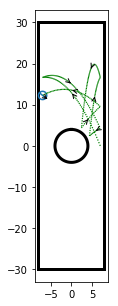

In [0]:
#@title Interactive {run: "auto"}
plot_steps=7 #@param {type:"slider", min:0, max:50, step:1}

ax = draw(part, step_count=plot_steps, show_arrows=True)
plt.show()

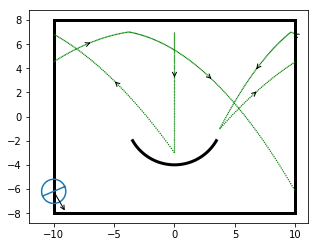

I will attempt to animate 200 frames


CPU times: user 22.3 s, sys: 14.5 s, total: 36.8 s
Wall time: 19.2 s


In [0]:
## No-Slip Law
np.seterr(all='raise')  # stops program when "warnings" occur.  Default is to continue, but this option makes debugging easier
np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 1000
dim = 2

channel_radius = 8
channel_length = 10


######### Make particle #########
part = Particle(radius=1.0, force = [0.0,-0.3], save=True)



######### Make walls #########
Walls = []

new_wall = FlatWall(base=[0,channel_radius], normal=[0,1], radius=channel_length, collision_law='no_slip')
Walls.append(new_wall)

new_wall = FlatWall(base=[0,-channel_radius], normal=[0,-1], radius=channel_length, collision_law='no_slip')
Walls.append(new_wall)

new_wall = FlatWall(base=[channel_length,0], normal=[1,0], radius=channel_radius, collision_law='wrap',
                    wrap_wall_idx=3, hard=False, flip_pos=True, flip_vel=True)
Walls.append(new_wall)

new_wall = FlatWall(base=[-channel_length,0], normal=[-1,0], radius=channel_radius, collision_law='wrap',
                    wrap_wall_idx=2, hard=False, flip_pos=True, flip_vel=True)
Walls.append(new_wall)

scatterer_radius = 4
new_wall = SphereWall(base=[0.0, 0.0], radius=scatterer_radius, max_polar_angle = np.pi/3,
                      north=[0,-1], collision_law='no_slip')
Walls.append(new_wall)


######### Initialize Particle #########
start_wall_idx = 0
part.wall_idx = start_wall_idx
start_wall = Walls[start_wall_idx]
part.pos = start_wall.base - start_wall.normal * part.radius
part.vel = np.array([0.0, -1])
part.spin = 2.0



######### Run it #########
run(part, Walls)


######### Draw history #########
ax = draw(part, step_count=10)
plt.show()

######### Animate #########
%time part, anim = animate(part, movie_time=5, show_trails=True, save=True)

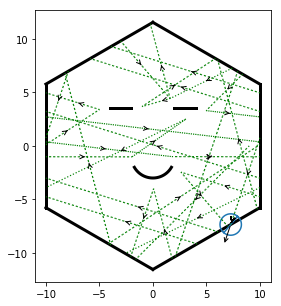

In [0]:
## Wrap Law
np.seterr(all='raise')  # stops program when "warnings" occur.  Default is to continue, but this option makes debugging easier
np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 100
dim = 2

polygon_sides = 6
polygon_radius_inscribed = 10
assert polygon_sides % 2 == 0, "I only know how to wrap with an even number of sides"
offset = int(polygon_sides / 2)


######### Make particle #########
part = Particle(radius=1.0, save=True)


######### Make walls #########
Walls = []

length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
    n = np.array([np.cos(theta), np.sin(theta)])
    b = n * polygon_radius_inscribed
    wrap_wall_idx = (i + offset) % polygon_sides
    new_wall = FlatWall(base=b, normal=n, radius=length, collision_law='wrap',
                        wrap_wall_idx=wrap_wall_idx, hard=False, flip_pos=True, flip_vel=True)
    Walls.append(new_wall)


scatterer_radius = 2
assert (scatterer_radius < polygon_radius_inscribed), "scatterer won't fit in the polygon"  # checks that the scatterer fits
new_wall = SphereWall(base=[0.0, -1.0], radius=scatterer_radius, max_polar_angle = np.pi/3,
                      north=[0,-1], collision_law='no_slip')
Walls.append(new_wall)


new_wall = FlatWall(base=[-3.0,3.5], normal=[0,1], radius=1, two_sided=True, collision_law='no_slip')
Walls.append(new_wall)


new_wall = FlatWall(base=[3.0,3.51], normal=[0,1], radius=1, two_sided=True, collision_law='no_slip')
Walls.append(new_wall)


######### Initialize Particle #########
start_wall_idx = 0
part.wall_idx = start_wall_idx
start_wall = Walls[start_wall_idx]
part.pos = start_wall.base - start_wall.normal * part.radius
part.vel = part.vel = np.array([-1.0, -1.0])
part.spin = 0.5



######### Run it #########
run(part, Walls)


######### Draw history #########
ax = draw(part, step_count=50)
plt.show()

######### Animate #########
# %time part, anim = animate(part, movie_time=5, show_trails=True, save=True)

In [0]:
## Specular Law


np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 5000
dim = 2


######### Make particle #########
part = Particle(radius=1.0, save=True)


######### Make walls #########
Walls = []
polygon_sides = 7
polygon_radius_inscribed = 10


length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
    n = np.array([np.cos(theta), np.sin(theta)])
    b = n * polygon_radius_inscribed
    new_wall = FlatWall(base=b, normal=n, radius=length)
    Walls.append(new_wall)


scatterer_radius = 2
assert (scatterer_radius < polygon_radius_inscribed), "scatterer won't fit in the polygon"  # checks that the scatterer fits
new_wall = SphereWall(base=[0.0, -1.0], radius=scatterer_radius, max_polar_angle = np.pi/3,
                      north=[0,-1], collision_law='specular')
Walls.append(new_wall)


new_wall = FlatWall(base=[-3.0,3.5], normal=[0,1], radius=1, two_sided=True, collision_law='specular')
Walls.append(new_wall)


new_wall = FlatWall(base=[3.0,3.51], normal=[0,1], radius=1, two_sided=True, collision_law='specular')
Walls.append(new_wall)



######### Initialize Particle #########
start_wall_idx = 0
part.wall_idx = start_wall_idx
start_wall = Walls[start_wall_idx]
part.pos = np.array([3.1, 7.0])
part.vel = np.array([0.0, -1.1])
part.spin = 4.5


######### Run it #########
run(part, Walls)


######### Draw history #########
ax = draw(part, step_count=1000)
plt.show()

######### Animate #########
# %time part, anim = animate(part, movie_time=5, show_trails=True, save=True)

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f4dc3a28378> (for post_execute):


KeyboardInterrupt: ignored

In [0]:
# To demostrate that we have recorded enough data in the json_record to fully
# recreate the experiment, we delete part and re-construct it from the json_record only.

path = part.save_path
del part, Walls

with open(path+"data.json", "r") as file:
    part = json.load(file)

for key, val in part.items():
    if isinstance(val, list):
        part[key] = np.array(val)  # Turns lists to arrays for convenience

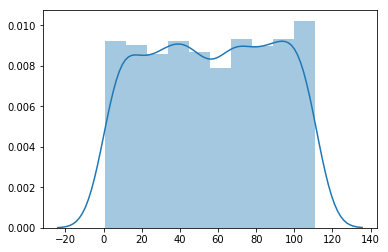

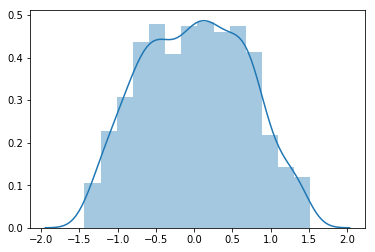

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
arc = part['arclength_hist'].copy()
arc = arc[~np.isnan(arc)]
sns.distplot(arc)
plt.show()

phi = part['phi_hist'].copy()
phi = phi[~np.isnan(phi)]
sns.distplot(phi)
plt.show()